In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential, Model
from keras.layers import Dense, Reshape, Flatten, Dropout, LeakyReLU, Input, BatchNormalization, Concatenate, Conv2D, Conv2DTranspose, Activation
from keras.optimizers import Adam
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from keras.applications import VGG16
from keras import backend as K

In [ ]:
def load_data(data_dir, img_size=(128, 128)):
    images = []
    labels = []
    for label in os.listdir(data_dir):
        for img_file in os.listdir(os.path.join(data_dir, label)):
            img_path = os.path.join(data_dir, label, img_file)
            if img_file.lower().endswith(('.jpeg','.jpg')):
                try:
                    img = load_img(img_path, target_size=img_size)
                    img = img_to_array(img) / 255.0
                    images.append(img)
                    labels.append(label)
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")
                    continue
    return np.array(images), np.array(labels)

data_dir = '/content/drive/MyDrive/dataset_image'  # Update this path
X, y = load_data(data_dir)

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)


Error loading image /content/drive/MyDrive/dataset_image/Ocimum Tenuiflorum (Tulsi)/holy-basil-tulsi-leaves-isolated-white_256988-866.jpg: cannot identify image file <_io.BytesIO object at 0x7f223a5029d0>


In [ ]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
# Build Generator
def build_generator(latent_dim, num_classes):
    model = Sequential()
    model.add(Dense(128 * 32 * 32, activation="relu", input_dim=latent_dim + num_classes))
    model.add(Reshape((32, 32, 128)))
    model.add(BatchNormalization())

    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Conv2DTranspose(3, kernel_size=4, strides=1, padding='same', activation='tanh'))
    return model

# Build Discriminator
def build_discriminator(img_shape, num_classes):
    model = Sequential()
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(128, activation=LeakyReLU(alpha=0.2)))
    model.add(Dropout(0.3))

    # Add a layer to incorporate class labels
    model.add(Dense(128, activation=LeakyReLU(alpha=0.2)))
    model.add(Dropout(0.3))

    # Change the output layer to predict num_classes + 1 values
    model.add(Dense(num_classes + 1, activation='sigmoid'))  # num_classes + 1 for real/fake + class
    return model

def build_gan(generator, discriminator):
    discriminator.compile(loss='categorical_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
    discriminator.trainable = False
    gan_input = Input(shape=(latent_dim + num_classes,))
    img = generator(gan_input)
    gan_output = discriminator(img)
    gan = Model(gan_input, gan_output)
    gan.compile(loss='categorical_crossentropy', optimizer=Adam(0.0002, 0.5))
    return gan

# Define latent_dim and num_classes
latent_dim = 100
num_classes = len(np.unique(y))

In [ ]:
img_shape = (128, 128, 3)
generator = build_generator(latent_dim, num_classes)
discriminator = build_discriminator(img_shape, num_classes)
gan = build_gan(generator, discriminator)

# Training the GAN
def train_gan(epochs, batch_size, latent_dim):
    for epoch in range(epochs):
        # Select a random batch of images
        idx = np.random.randint(0, X.shape[0], batch_size)
        real_imgs = X[idx]
        labels = y[idx]

        # One-hot encode labels for the real images
        labels_encoded = np.zeros((batch_size, num_classes))
        labels_encoded[np.arange(batch_size), LabelEncoder().fit(y).transform(labels)] = 1

        # Generate noise and concatenate with labels for the generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        noise_with_labels = np.concatenate((noise, labels_encoded), axis=1)
        fake_imgs = generator.predict(noise_with_labels)

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(real_imgs, np.ones((batch_size, 1)))  # Real images labeled as 1
        d_loss_fake = discriminator.train_on_batch(fake_imgs, np.zeros((batch_size, 0)))  # Fake images labeled as 0
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        noise_with_labels = np.concatenate((noise, labels_encoded), axis=1)
        g_loss = gan.train_on_batch(noise_with_labels, np.ones((batch_size, 1)))  # Labels for generator are all 1

        # Print the progress
        #if epoch % 10 == 0:
            #print(f"{epoch} [D loss: {d_loss[0]:.4f}, acc.: {100 * d_loss[1]:.2f}%] [G loss: {g_loss:.4f}]")
# Train the GAN
train_gan(epochs=1000, batch_size=32, latent_dim=latent_dim)

# Generate synthetic images
def generate_images(generator, num_images):
    noise = np.random.normal(0, 1, (num_images, latent_dim))
    labels = np.random.randint(0, num_classes, num_images)
    labels_encoded = np.zeros((num_images, num_classes))
    labels_encoded[np.arange(num_images), labels] = 1
    noise_with_labels = np.concatenate((noise, labels_encoded), axis=1)
    generated_images = generator.predict(noise_with_labels)
    return generated_images

# After generating synthetic images
synthetic_images = generate_images(generator, 300)

# Function to display the first 5 real and synthetic images
def display_real_and_synthetic_images(real_images, synthetic_images, num_images=5):
    plt.figure(figsize=(10, 4))

    # Display real images
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(real_images[i])  # No cmap argument for color images
        plt.axis('off')  # Hide the axis
        plt.title("Real Image")

    # Display synthetic images
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(synthetic_images[i])  # No cmap argument for color images
        plt.axis('off')  # Hide the axis
        plt.title("Synthetic Image")

    plt.tight_layout()
    plt.show()

# Display the first 5 real images and the first 5 synthetic images
display_images(synthetic_images, num_images=5)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(32, 1), output.shape=(32, 21)

In [ ]:
import matplotlib.pyplot as plt

# Function to display the first 3 images
def display_images(images, num_images=3):
    plt.figure(figsize=(10, 4))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])  # No cmap argument for color images
        plt.axis('off')  # Hide the axis
    plt.show()

# Display the first 3 synthetic images
display_images(synthetic_images)

NameError: name 'synthetic_images' is not defined

In [ ]:
# Feature extraction
def extract_features(images):
    model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    features = model.predict(images)
    return features.reshape(features.shape[0], -1)

real_features = extract_features(X)

# Combine features and labels only for real images
combined_features = real_features
combined_labels = y

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(combined_labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(combined_features, encoded_labels, test_size=0.2, random_state=42)

# Train the logistic regression model
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)

# Make predictions
y_pred = logistic_model.predict(X_test)

# Generate classification report
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Calculate accuracy
accuracy = logistic_model.score(X_test, y_test)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 15s 99ms/step
                                   precision    recall  f1-score   support

 Amaranthus Viridis (Arive-Dantu)       0.91      0.87      0.89        55
        Azadirachta Indica (Neem)       0.96      0.96      0.96        51
          Bauhinia racemosa(Apta)       0.94      0.86      0.90        59
              Eucalyptus(Nilgiri)       0.96      0.93      0.94        69
    Ficus Religiosa (Peepal Tree)       0.86      0.91      0.88        67
         Mangifera Indica (Mango)       0.89      0.97      0.93        58
                    Mentha (Mint)       0.89      0.91      0.90        64
       Ocimum Tenuiflorum (Tulsi)       0.85      0.81      0.83        57
Peltophorum pterocarpum(Sonmohar)       0.89      0.96      0.92        56
      Zingiber officinale(Ginger)       1.00      0.88      0.93        24

                         accuracy                           0.91       560
      

                                   precision    recall  f1-score   support

 Amaranthus Viridis (Arive-Dantu)       0.91      0.87      0.89        55
        Azadirachta Indica (Neem)       0.96      0.96      0.96        51
          Bauhinia racemosa(Apta)       0.94      0.86      0.90        59
              Eucalyptus(Nilgiri)       0.96      0.93      0.94        69
    Ficus Religiosa (Peepal Tree)       0.86      0.91      0.88        67
         Mangifera Indica (Mango)       0.89      0.97      0.93        58
                    Mentha (Mint)       0.89      0.91      0.90        64
       Ocimum Tenuiflorum (Tulsi)       0.85      0.81      0.83        57
Peltophorum pterocarpum(Sonmohar)       0.89      0.96      0.92        56
      Zingiber officinale(Ginger)       1.00      0.88      0.93        24

                         accuracy                           0.91       560
                        macro avg       0.91      0.91      0.91       560
                     we

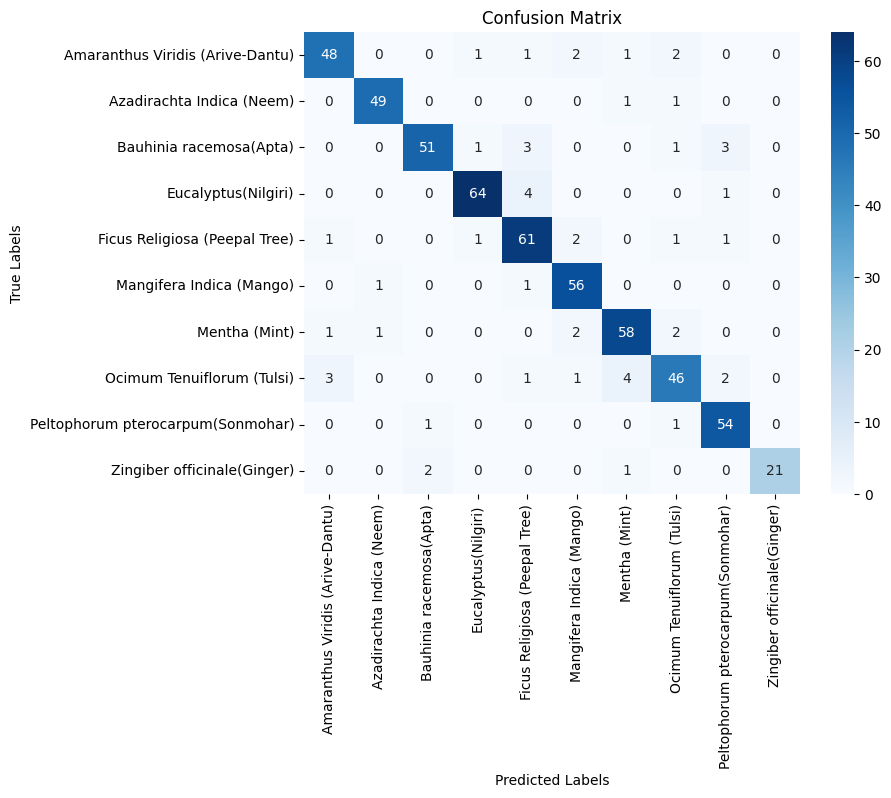

In [ ]:
# prompt: accuracy, precision, recall, F1-score, and a confusion matrix,  given to the "macro average

from sklearn.metrics import confusion_matrix
import seaborn as sns

# ... (Your existing code) ...

# Make predictions
y_pred = logistic_model.predict(X_test)

# Generate classification report
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Calculate accuracy
accuracy = logistic_model.score(X_test, y_test)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

# Compute and print the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# prompt: auc_roc score for the above model

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Assuming y_test and y_pred are your true and predicted labels
# Binarize the labels for multi-class ROC AUC
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_pred_bin = label_binarize(y_pred, classes=np.unique(y_test))

# Calculate ROC AUC for each class
auc_roc_scores = roc_auc_score(y_test_bin, y_pred_bin, average=None)

# Print ROC AUC for each class
print("AUC ROC scores for each class:")
for i, score in enumerate(auc_roc_scores):
    print(f"Class {le.classes_[i]}: {score}")

# Calculate the average ROC AUC across all classes
average_auc_roc = roc_auc_score(y_test_bin, y_pred_bin, average='macro')
print(f"\nAverage AUC ROC: {average_auc_roc}")


AUC ROC scores for each class:
Class Amaranthus Viridis (Arive-Dantu): 0.9314131413141313
Class Azadirachta Indica (Neem): 0.9784275203205055
Class Bauhinia racemosa(Apta): 0.9292093778544604
Class Eucalyptus(Nilgiri): 0.9607131261253286
Class Ficus Religiosa (Peepal Tree): 0.9450818927674002
Class Mangifera Indica (Mango): 0.9757865091358704
Class Mentha (Mint): 0.9460685483870966
Class Ocimum Tenuiflorum (Tulsi): 0.8955564856475184
Class Peltophorum pterocarpum(Sonmohar): 0.9751984126984128
Class Zingiber officinale(Ginger): 0.9375

Average AUC ROC: 0.9474955014250724


In [ ]:
import joblib
from keras.models import save_model
from keras.applications import VGG16

# Assuming you have already defined and trained your logistic regression model
# Save the logistic regression model
joblib.dump(logistic_model, 'logistic_model.pkl')

# Save the VGG16 feature extractor
vgg16_feature_extractor = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
save_model(vgg16_feature_extractor, 'vgg16_feature_extractor.keras')
joblib.dump(le, 'label_encoder.pkl')


['label_encoder.pkl']

In [ ]:
# Predicting new images
def load_and_preprocess_image(image_path, img_size=(128, 128)):
    img = load_img(image_path, target_size=img_size)
    img = img_to_array(img) / 255.0
    img = np.expand_dims(img, axis=0)
    return img

def predict_image(image_path, model, feature_extractor):
    img = load_and_preprocess_image(image_path)
    features = feature_extractor.predict(img)
    features = features.reshape(features.shape[0], -1)
    prediction = model.predict(features)
    return prediction

# Example usage
image_path = '/content/chinch.jpg'  # Replace with the path to your test image
img = load_img(image_path, target_size=(128, 128))  # Load with target size for display
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

# Load feature extractor once outside the prediction function
feature_extractor = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

predicted_class = predict_image(image_path, logistic_model, feature_extractor)

# Decode the predicted class
predicted_label = le.inverse_transform(predicted_class)
print(f"Predicted class: {predicted_label[0]}")

FileNotFoundError: [Errno 2] No such file or directory: '/content/chinch.jpg'